In [ ]:
# credits - https://github.com/a-forty-two/gaip-dl-12-22/blob/main/12_Object_Detection%20(1).ipynb
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.backend import set_session
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
rootPath = '/content/gdrive/My Drive/Dataset/GarbageClassification/'
classNames = sorted(os.listdir(rootPath))
nClasses = len(classNames)
print(f"Number of Classes : {nClasses}")

Number of Classes : 6


In [ ]:
classDistribution = [len(os.listdir(rootPath + name)) for name in classNames]
classDistribution

[403, 501, 410, 594, 482, 137]

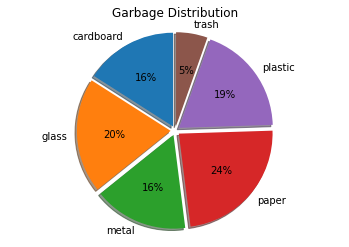

In [ ]:
# plt.pie(labels=classNames, x=classDistribution, autopct='%.0f%%')
labels = classNames
sizes = classDistribution
fig1, ax1 = plt.subplots()
explode = (0.05,0.05,0.05,0.05,0.05,0.05)
ax1.pie(sizes, labels=labels, explode=explode, autopct='%.0f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Garbage Distribution")
plt.show()

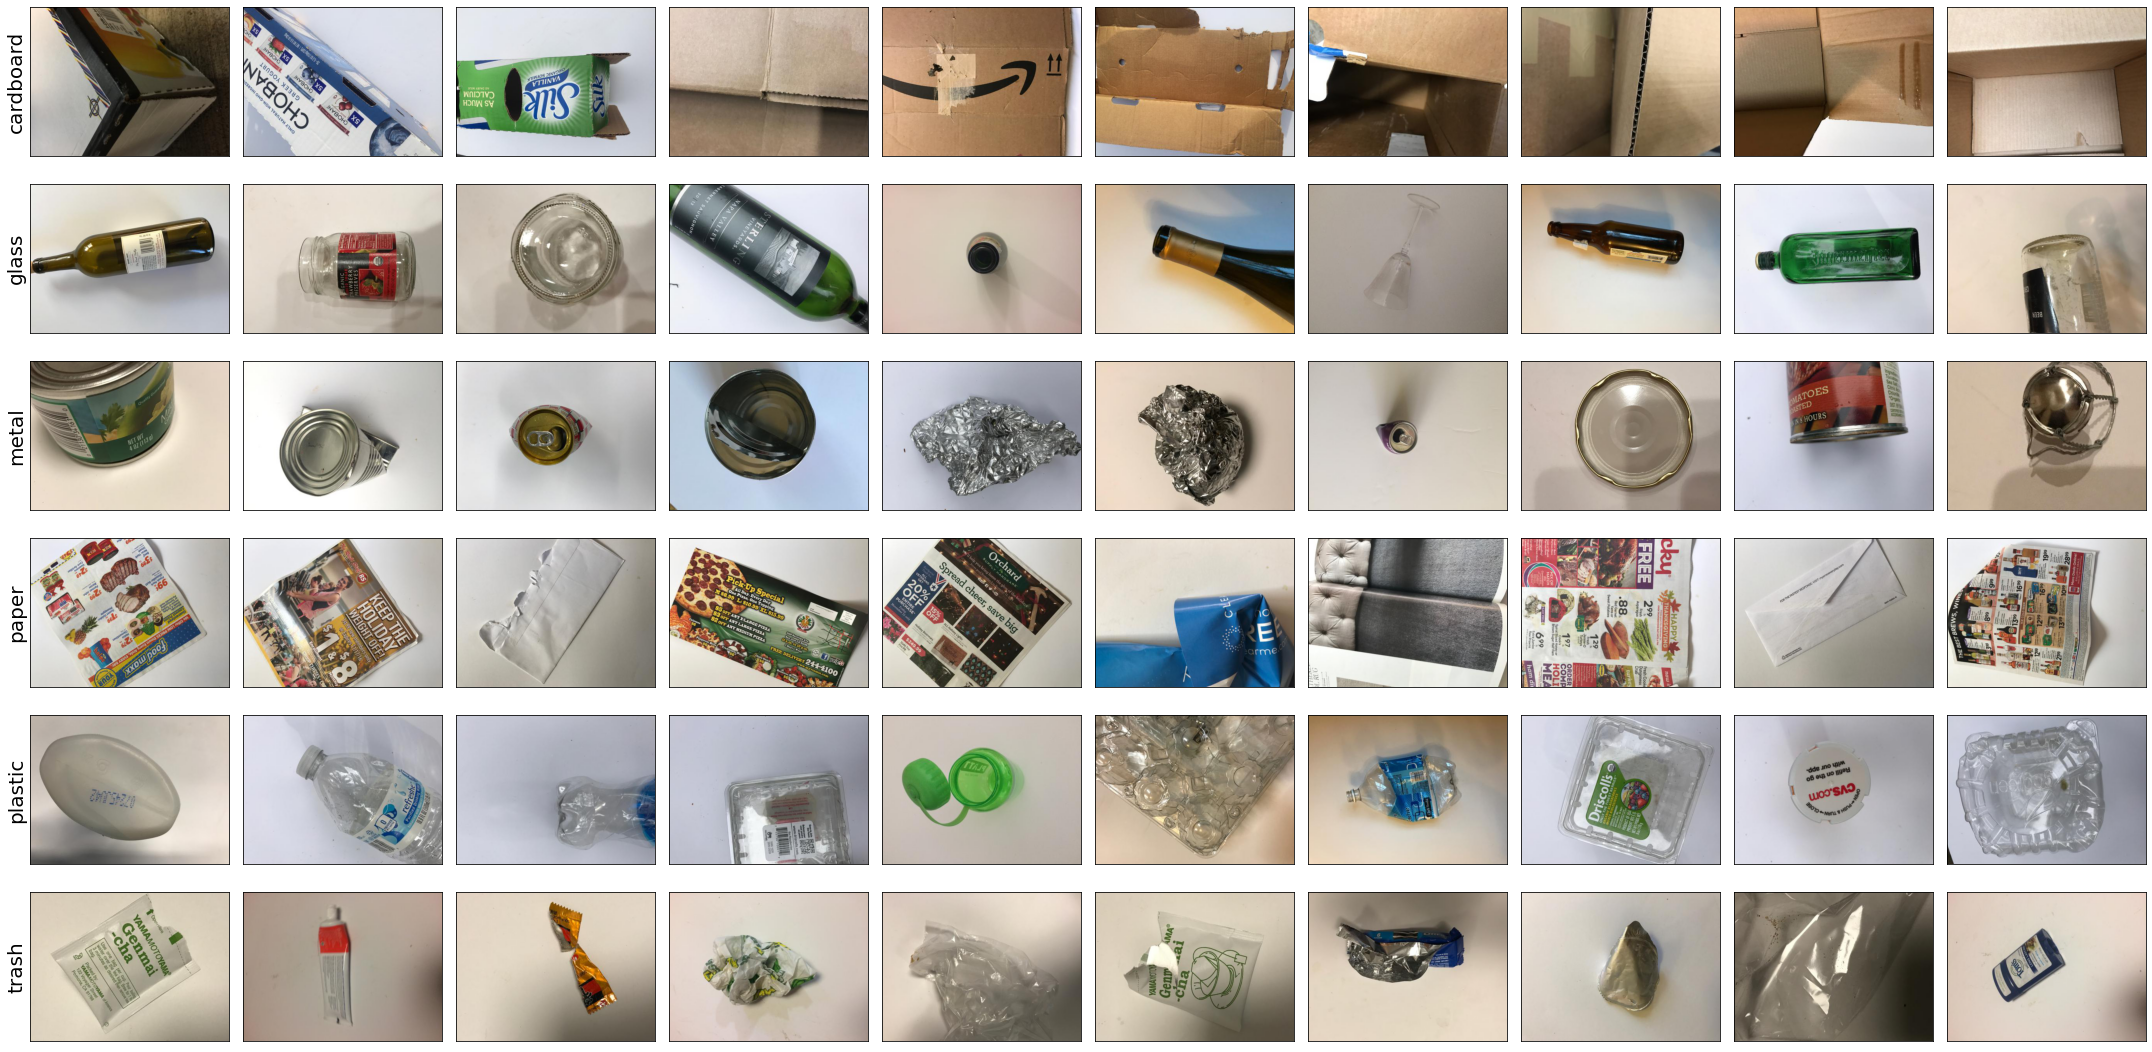

In [ ]:
import matplotlib.image as mpimg
train = os.path.join(rootPath)
plt.figure(figsize=(30,15))
for i in range(6):
    directory = os.path.join(train, labels[i])
    for j in range(10):
        path = os.path.join(directory, os.listdir(directory)[j])
        img = mpimg.imread(path)
        plt.subplot(6, 10, i*10 + j + 1)
        plt.imshow(img)
        if j == 0:
            plt.ylabel(labels[i], fontsize=20)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.tight_layout()
plt.show()

In [ ]:
# %tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
import numpy as np
from keras import backend
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.models import Sequential

2.9.2


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from tensorflow.keras.regularizers import l1, l2, L1L2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow
tensorflow.random.set_seed(0)
np.random.seed(0)

In [ ]:
train_garbage=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.2,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

test_garbage=ImageDataGenerator(rescale=1/255,
                        validation_split=0.2)

train_generator_g=train_garbage.flow_from_directory(rootPath,
                                          target_size=(100,100),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training',seed=42)

test_generator_g=test_garbage.flow_from_directory(rootPath,
                                        target_size=(100,100),
                                        batch_size=32,
                                        class_mode='categorical',
                                        subset='validation',seed=42)

labels = (train_generator_g.class_indices)
print(labels)
labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [ ]:
# PandaVGG = ((Conv + ReLU + BN) + MP + Dropout + ( (Conv + ReLU + BN) + MP + Dropout)XN
# + (Flatten + Dense(ReLu) + Dense(SoftMax))

class PandaVGG:
  @staticmethod
  def build( height, width, depth, classes) :
    # let's assume we are on TF
    inputShape = (height, width, depth)
    channel_dim = -1  # last element -> CHANNELS_LAST
    if backend.image_data_format() == 'channels_first':
      inputShape = (depth, height, width)
      channel_dim = 1
    # { data, representation } => [data,representation] or [representation, data]
    # { images, channels } => channels_last or channels_first
    # data -> 2 d images -> height [row], width [columns]

    HP_block1_conv_dim = 32
    HP_small_pattern = (3,3)
    HP_block2_conv_dim = 64
    HP_block3_conv_dim = 128
    HP_block4_conv_dim = 256
    HP_block5_dense_dim = 1024
    HP_large_pattern = (2,2)
    HP_dropout_type1 = 0.25
    HP_dropout_type2 = 0.50

    model = Sequential()
    # PandaVGG = (Conv + ReLU + BN) + MP + Dropout + ((Conv + ReLU + BN)X2 + MP + Dropout) X N
    # + (Flatten + Dense(ReLu) + Dense(SoftMax))

    # Block1 starts-> (Conv + ReLU + BN) + MP + Dropout
    model.add(Conv2D(HP_block1_conv_dim, HP_small_pattern, padding='same', input_shape=inputShape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim)) # our data needs to be normalized, not our channels
    model.add(MaxPooling2D(pool_size=HP_small_pattern))
    model.add(Dropout(HP_dropout_type1))
    # Block1 complete

    # Block2 starts -> (Conv + RelU + BN) X2 + Compress + Drop
    model.add(Conv2D(HP_block2_conv_dim,HP_small_pattern, padding='same' ))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(Conv2D(HP_block2_conv_dim,HP_small_pattern, padding='same' ))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D(pool_size=HP_large_pattern))
    model.add(Dropout(HP_dropout_type1))
    # Block 2 ends

    # Block3 starts
    model.add(Conv2D(HP_block3_conv_dim,HP_small_pattern, padding='same' ))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(Conv2D(HP_block3_conv_dim,HP_small_pattern, padding='same' ))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D(pool_size=HP_large_pattern))
    model.add(Dropout(HP_dropout_type1))
    # Block3 ends

    # Block4 starts
    model.add(Conv2D(HP_block4_conv_dim,HP_small_pattern, padding='same' ))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(Conv2D(HP_block4_conv_dim,HP_small_pattern, padding='same' ))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D(pool_size=HP_large_pattern))
    model.add(Dropout(HP_dropout_type1))
    # Block4 ends

    # final block5- classification/prediction
    model.add(Flatten())
    model.add(Dense(HP_block5_dense_dim))
    model.add(Activation('relu'))
    # optional: Batch Normalization and Dropout -> to avoid overfitting
    model.add(BatchNormalization())
    model.add(Dropout(HP_dropout_type2))
    model.add(Dense(classes))
    model.add(Activation('softmax'))
    # final block ends

    return model

In [ ]:
model = PandaVGG.build(96, 96, 3, 6)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
from sklearn.preprocessing import LabelBinarizer
import cv2
import numpy as np
import random
import imutils
from imutils import paths
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from sklearn.model_selection import train_test_split

In [ ]:
HP_epoch = 100
HP_init_lr = 1e-3
HP_batch_size = 32
HP_image_dim = (96,96,3)

In [ ]:
data = []
labels = []
all_images = sorted(list(paths.list_images(rootPath)))
all_images[:5]

['/content/gdrive/My Drive/Dataset/GarbageClassification/cardboard/cardboard1.jpg',
 '/content/gdrive/My Drive/Dataset/GarbageClassification/cardboard/cardboard10.jpg',
 '/content/gdrive/My Drive/Dataset/GarbageClassification/cardboard/cardboard100.jpg',
 '/content/gdrive/My Drive/Dataset/GarbageClassification/cardboard/cardboard101.jpg',
 '/content/gdrive/My Drive/Dataset/GarbageClassification/cardboard/cardboard102.jpg']

In [ ]:
random.seed(42)
random.shuffle(all_images)
all_images[:5]
print(len(all_images))

2527


In [ ]:
import os
for impath in all_images:
  img = cv2.imread(impath)
  resized = cv2.resize(img, (HP_image_dim[0],HP_image_dim[1]) )
  imageData = img_to_array(resized)
  data.append(imageData)
  label = impath.split(os.path.sep)[-2]
  labels.append(label)
print(len(labels))

4605


In [ ]:
labels = np.array(labels)
lb = LabelBinarizer()
binarized_labels = lb.fit_transform(labels)
print(binarized_labels[0])
print(binarized_labels[1])
print(len(binarized_labels))

[0 1 0 0 0 0]
[0 0 0 1 0 0]
4605


In [ ]:
binarized_labels[0].dtype

dtype('int64')

In [ ]:
norm_data = np.array(data, dtype='float') / 255
trainx, testx, trainy, testy = train_test_split(
    norm_data,binarized_labels,test_size=0.2,random_state=42)

aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

In [ ]:
print(len(trainx))
print(len(trainy))

3684
3684


In [ ]:
class CorrectPandaVGG:
  @staticmethod
  def create(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    if backend.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
      chanDim = 1
    model.add(Conv2D(32,(3,3), padding='same', input_shape=inputShape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64,(3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64,(3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128,(3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128,(3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256,(3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(256,(3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))

    model.add(Dense(classes))
    model.add(Activation('softmax'))
    return model

In [ ]:
from keras.optimizers import Adam
model = CorrectPandaVGG.create(HP_image_dim[0], HP_image_dim[1], HP_image_dim[2],len(lb.classes_))
optimizer = Adam(lr=HP_init_lr, decay= HP_init_lr/HP_epoch)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit_generator(aug.flow(
    trainx, trainy, batch_size=HP_batch_size), validation_data=(testx,testy),
    steps_per_epoch = len(trainx)// HP_batch_size,epochs=HP_epoch)

<ipython-input-23-8a110b460653>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(aug.flow(


Epoch 1/100
115/115 [==============================] - 19s 84ms/step - loss: 2.2729 - accuracy: 0.4693 - val_loss: 3.6507 - val_accuracy: 0.2248
Epoch 2/100
115/115 [==============================] - 9s 76ms/step - loss: 1.1498 - accuracy: 0.5802 - val_loss: 2.6241 - val_accuracy: 0.2020
Epoch 3/100
115/115 [==============================] - 9s 77ms/step - loss: 0.9911 - accuracy: 0.6396 - val_loss: 1.8822 - val_accuracy: 0.3018
Epoch 4/100
115/115 [==============================] - 9s 76ms/step - loss: 0.9273 - accuracy: 0.6684 - val_loss: 1.5890 - val_accuracy: 0.4734
Epoch 5/100
115/115 [==============================] - 9s 75ms/step - loss: 0.8044 - accuracy: 0.7100 - val_loss: 1.1693 - val_accuracy: 0.6211
Epoch 6/100
115/115 [==============================] - 9s 75ms/step - loss: 0.7847 - accuracy: 0.7174 - val_loss: 0.9615 - val_accuracy: 0.6384
Epoch 7/100
115/115 [==============================] - 9s 76ms/step - loss: 0.6848 - accuracy: 0.7486 - val_loss: 1.5245 - val_accuracy

In [ ]:
import pickle
import numpy as np
import imutils
import cv2
import os
from tensorflow.keras.utils import img_to_array
from keras.models import load_model

HP_model_path = '/content/gdrive/My Drive/Dataset/Model/VGG16.h5'

# model.load()
# model.compile()

HP_test_img = '/content/gdrive/My Drive/Dataset/GarbageClassification/cardboard/cardboard3.jpg'
img = cv2.imread(HP_test_img)
copy_img = img.copy()
img = cv2.resize(img, (96,96))
img = (img*1.0)/255.0
img_to_feed_nn = np.expand_dims(img, axis=0)

In [ ]:
prediction = model.predict(img_to_feed_nn)
print(prediction)

1/1 [==============================] - 0s 326ms/step
[[9.9999964e-01 1.5670453e-11 4.8035547e-12 1.7648402e-10 3.7051430e-07
  1.5697931e-09]]


Hence it is Cardboard

In [ ]:
# from sklearn import metrics
# confusion_matrix = metrics.confusion_matrix(testy, predict)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
# cm_display.plot()
# plt.show()

In [ ]:
from sklearn.preprocessing import LabelBinarizer
LABELS=["CARDBOARD","GLASS","METAL","PAPER","PLASTIC","TRASH"]

In [ ]:
# def predict(imagePath):
#     # load the input image (in Keras format) from disk and preprocess
#     # it, scaling the pixel intensities to the range [0, 1]
#     image = cv2.imread(imagePath)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     output = image.copy()
#     image = cv2.resize(image, (224, 224))
#     image = image.astype("float") / 255.0
#     image = img_to_array(image)
#     image = np.expand_dims(image, axis=0)
#     # make bounding box predictions on the input image
#     proba = model.predict(image)[0]
#     idx = np.argmax(proba)
#     label = lb.classes_[idx]
#     label = "{}: {:.2f}% ".format(label, proba[idx] * 100)
#     cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
#         0.7, (255, 0, 0), 2)
#     # show the output image
#     fig=plt.figure(figsize=(10,10))
#     plt.grid(b=None)
#     plt.axis('off')
#     return plt.imshow(output)